## SARIMA Justification

- The strong autocorrelation for the room occupancy time series, suggest an autoregressive model such as ARMA or ARIMA or SARIMA
- The occupancy history is non-stationary and there is an upward trend, so the integrated component of ARIMA will automatically perform the differencing needed to transform the data into stationary data. So preferable to ARMA
- The strong seasonality suggests SARIMA would be most appropriate as it can process seasonal patterns. So preferable to ARIMA

SARIMA
- nb to be clear SARIMA stands for Seasonal Autoregressive Integrated Moving Average
- S: seasonal component, here handle the annual occupancy seasonality
- AR: autoregressive component .... p
- I: integrated, here handle the positive historical trend through differencing to make it stationary .... d
- MA: moving average component ...... q
- SARIMA(p,d,q)(P,D,Q),m
- p,d,q non-seasonal
- P,D,Q seasonal
- m the seasonality period, length of the seasonal cycle
- !! But this is daily, with an annual cycle so would be m=365 which is too large ??

Residuals .... ??
- Residuals plot
- ACF plot of residuals
- Durbin-Watson of residuals .... ?? be close to 2


Approach
- Confirm/Assess the autoregressive order (AR, p) and moving average order (MA, q). Using PACF plot and ACF plot respectively [repeat autocorrelation findings from previously?]
- Use the SARIMA(p,d,q)(P,D,Q,m) model
- Identify the best parameters using Auto Arima and using AIC (Akaike Information Criterion) to compare

- ?? daily 365d is too much
- ?? First evaluate using residuals ....

- Split data and use 3 years history to the train the model, then 1 year to evaluate its accuracy
- ??? Use accuracy measures MAE, RMSE, MAPE ....

Forecasting With model
- Make month forecast and demonstrate its use in the revenue/occupancy spreadsheet


## Data Load & Model Factors

- Load time series data
- Assess the autoregressive order (AR, p) - Using PACF plot
- Assess moving average order (MA, q) - Using ACF plot 


In [8]:
# Libraries
#

import numpy as np
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, pacf, pacf_ols
from statsmodels.stats.stattools import durbin_watson

import statsmodels.api as sm

import pmdarima as pm

import matplotlib.pyplot as plt
plt.style.use('ggplot') 
from pandas.plotting import lag_plot


In [9]:
# Establish valid data file path, for reading and saving eg CSV files
#

import os
data_directory = 'Data_Sources'          # Designated data folder above the current working directory
project_directory = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(project_directory, data_directory)
if not os.path.isdir(DATA_PATH):
    raise Exception(f'Directory not found: {DATA_PATH}')

del data_directory, project_directory

In [10]:
# Load the time series CSV
#

# Load the states .csv file, exit if do not exist or are invalid
file_name = 'hotel_timeseries.csv'
file_path = os.path.join(DATA_PATH, file_name)
if not os.path.isfile(file_path):
    raise Exception(f'File not found: {file_path}')
hotel_time_series_df = pd.read_csv(file_path, parse_dates=['Date'])
hotel_time_series_df.set_index('Date', inplace=True)

# Tidy Up
del file_name, file_path

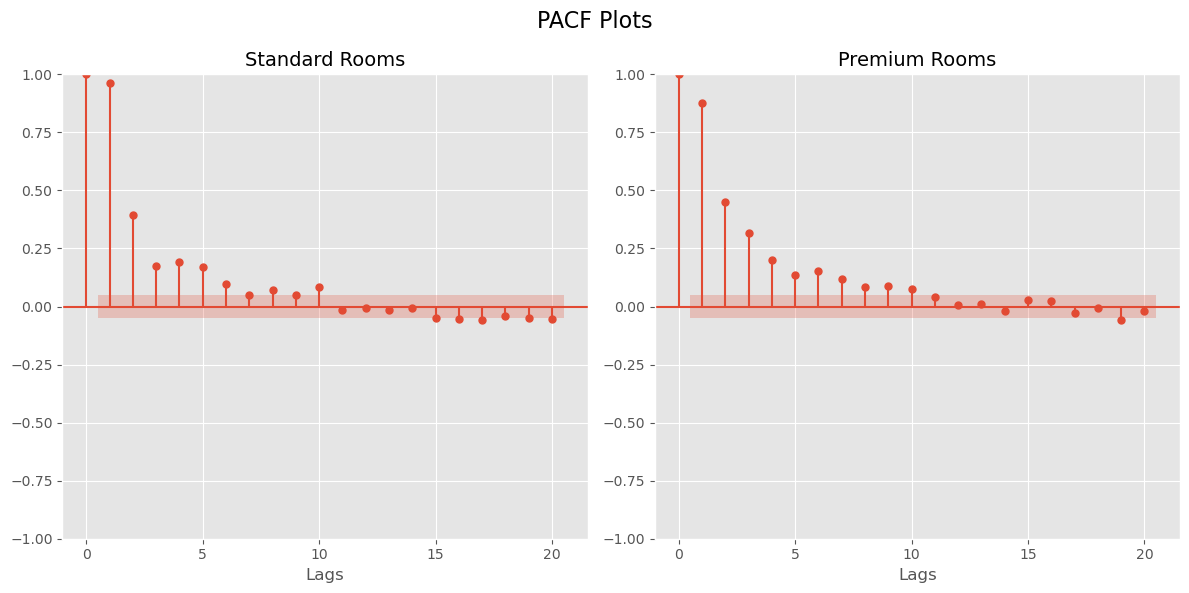

In [11]:
# Assess the autoregressive order (AR, p) - Using PACF plot
#

lag_value = 20

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('PACF Plots', fontsize=16)

# Plot for Standard Rooms
plot_pacf(hotel_time_series_df['Standard_OCC'], lags=lag_value, ax=ax1)
ax1.set_title('Standard Rooms', fontsize=14)
ax1.set_xlabel('Lags', fontsize=12)
#ax1.set_ylabel('PACF', fontsize=12)

# Plot for Premium Rooms
plot_pacf(hotel_time_series_df['Premium_OCC'], lags=lag_value, ax=ax2)
ax2.set_title('Premium Rooms', fontsize=14)
ax2.set_xlabel('Lags', fontsize=12)
#ax2.set_ylabel('PACF', fontsize=12)

plt.tight_layout()
plt.show()

PACF plot suggests AR order, p of approximately 3

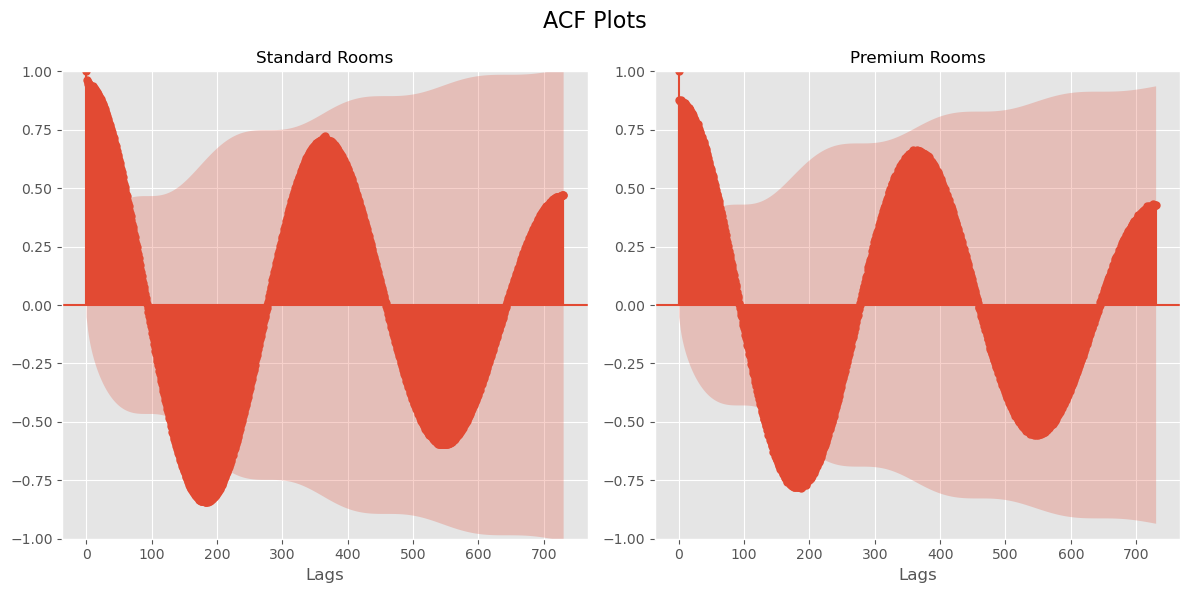

In [12]:
# Assess moving average order (MA, q) - Using ACF plot
#

lag_value = 730

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('ACF Plots', fontsize=16)

# Plot for Standard Rooms
plot_acf(hotel_time_series_df['Standard_OCC'], lags=lag_value, ax=ax1)
ax1.set_title('Standard Rooms', fontsize=12)
ax1.set_xlabel('Lags', fontsize=12)

# Plot for Premium Rooms
plot_acf(hotel_time_series_df['Premium_OCC'], lags=lag_value, ax=ax2)
ax2.set_title('Premium Rooms', fontsize=12)
ax2.set_xlabel('Lags', fontsize=12)

plt.tight_layout()
plt.show()

ACF plot suggests MA order q of approximately 60

## Establish Appropriate SARIMA Model


In [13]:
# Determine the SARIMA Model

# Earlier suggests: p=3, q=30
# Use auto arima to refine factors


auto_model = pm.auto_arima(
    hotel_time_series_df['Standard_OCC'],           
    start_p=3, max_p=3,         # Range for AR order
    d=1,                        # Differencing order (can be set to None to auto-detect)
    start_q=1, max_q=30,        # Range for MA order
    start_P=0, max_P=2,         # Range for seasonal AR order
    D=1,                        # Seasonal differencing order (can be set to None to auto-detect)
    start_Q=0, max_Q=2,         # Range for seasonal MA order
    m=7,                       # ????? Seasonal cycle length (12 for monthly data with yearly seasonality)
    seasonal=True,              # Enable seasonality
    stepwise=True,              # Enable stepwise search to reduce computation
    trace=True,                 # Print model details during the search
    information_criterion='aic' # Criterion for model selection
)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(3,1,1)(0,1,0)[7]             : AIC=12146.913, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=12698.288, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=11997.004, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=12459.366, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=11842.250, Time=0.50 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.24 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=12088.571, Time=0.18 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=11801.118, Time=0.55 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=11952.631, Time=0.32 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.42 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.56 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=11745.527, Time=0.66 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=11897.6

- Suggests ARIMA(3,1,1)(2,1,0),12 with AIC of 11554.722
- ?? earlier indicated q=30
- ?? m needs to be 365 but this fails as too long
- tried different differencing but comes back to 1

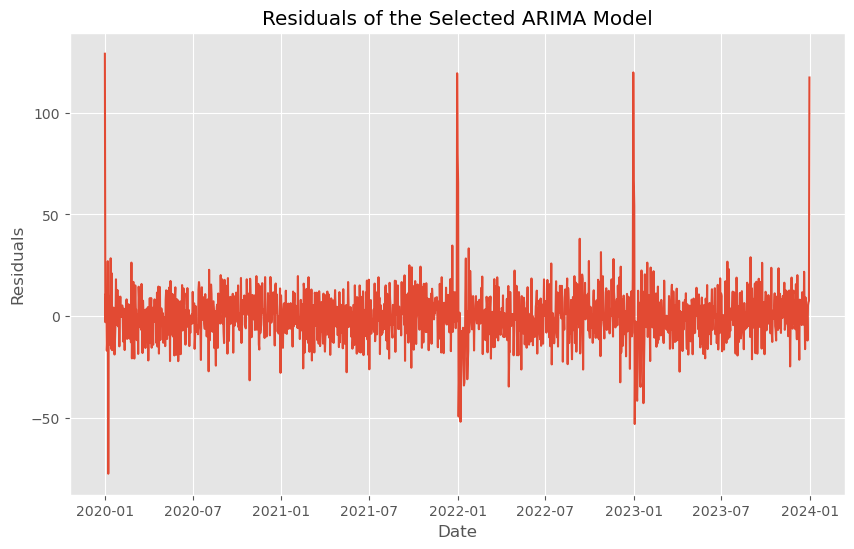

<Figure size 1000x600 with 0 Axes>

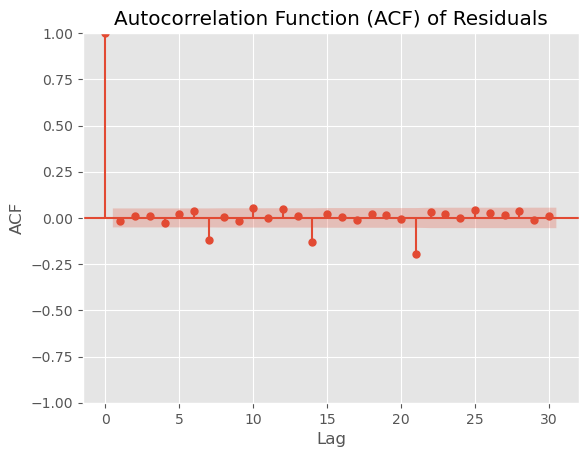

Durbin-Watson statistic of residuals: 1.9163240697181532


In [14]:
# Residual diagnostics for the selected AutoARIMA model
residuals = auto_model.arima_res_.resid  # Access the residuals without calling it as a function

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of the Selected ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(10,6))
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic of residuals: {dw_stat}')

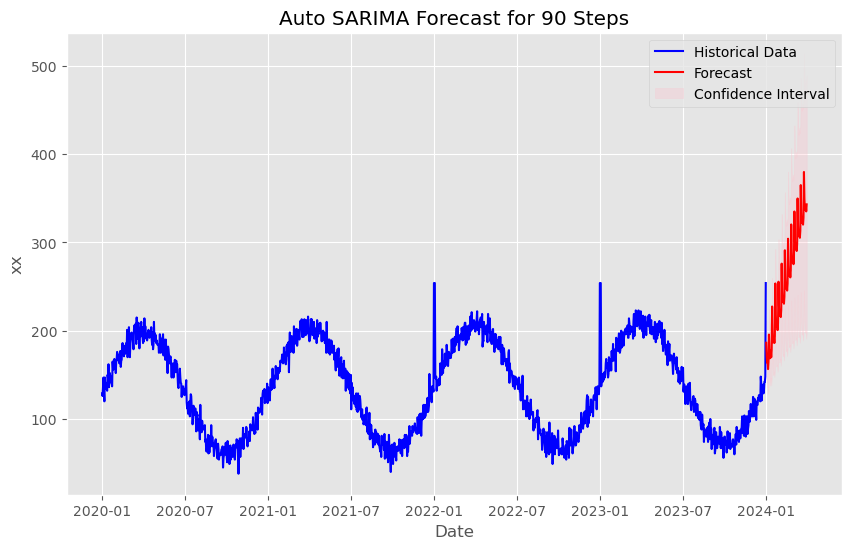

Forecasted values: 2024-01-01    186.378555
2024-01-02    170.088822
2024-01-03    163.755145
2024-01-04    165.248938
2024-01-05    156.532360
                 ...    
2024-03-26    337.269061
2024-03-27    339.509149
2024-03-28    342.305746
2024-03-29    335.156343
2024-03-30    343.139111
Freq: D, Length: 90, dtype: float64


In [15]:
# AutoARIMA Forecasting with Plot

# Define the number of steps you want to forecast
forecast_steps = 90  # Forecast the next 10 steps

# Forecast using the trained AutoARIMA model
forecast, conf_int = auto_model.predict(n_periods=forecast_steps, return_conf_int=True)

# Create a date range for the forecasted values
forecast_dates = pd.date_range(hotel_time_series_df.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Plot the historical data, forecast, and confidence interval
plt.figure(figsize=(10, 6))
plt.plot(hotel_time_series_df.index, hotel_time_series_df['Standard_OCC'], label='Historical Data', color='blue')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title(f'Auto SARIMA Forecast for {forecast_steps} Steps')
plt.xlabel('Date')
plt.ylabel('xx')
plt.legend()
plt.show()

print(f'Forecasted values: {forecast}')


## xxxxxxxxx

In [16]:
# Manual SARIMA Model Creation

model_sarima = sm.tsa.SARIMAX(hotel_time_series_df['Standard_OCC'], 
                             order=(3,1,1),
                             seasonal_order=(2,1,0,7))
model_fit = model_sarima.fit()

# Show the summary of results
print(model_fit.summary())



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14279D+00    |proj g|=  3.22671D-01

At iterate    5    f=  4.04196D+00    |proj g|=  5.74730D-02

At iterate   10    f=  4.00247D+00    |proj g|=  7.30059D-02

At iterate   15    f=  3.96395D+00    |proj g|=  7.29217D-03

At iterate   20    f=  3.96074D+00    |proj g|=  1.86310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     28      1     0     0   3.655D-06   3.961D+00
  F =   3.9606893748053262     

CONVERG

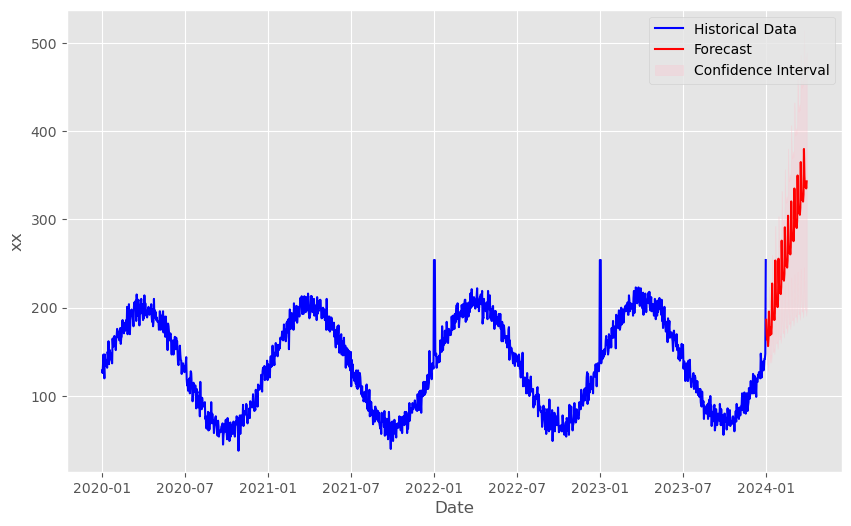

Forecasted values: <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper object at 0x34b743530>


In [18]:


# Create a forecast using the SARIMA model for the given time steps
forecast_steps = 90
forecast_dates = pd.date_range(hotel_time_series_df.index[-1], periods=forecast_steps + 1, freq='D')[1:]

forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

#forecast_values, forecast_conf_int = model_fit.predict(n_periods=forecast_steps, return_conf_int=True)


# Plot the historical data, forecast, and confidence interval
plt.figure(figsize=(10, 6))
plt.plot(hotel_time_series_df.index, hotel_time_series_df['Standard_OCC'], label='Historical Data', color='blue')
#plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.plot(forecast_dates, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_dates, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('xx')
plt.legend()
plt.show()

print(f'Forecasted values: {forecast}')

In [ ]:
auto_model = pm.auto_arima(
    hotel_time_series_df['Standard_OCC'],           
    start_p=1, max_p=3,         # Range for AR order
    start_q=1, max_q=3,         # Range for MA order
    start_P=0, max_P=2,         # Range for seasonal AR order
    start_Q=0, max_Q=2,         # Range for seasonal MA order
    d=1,                        # Differencing order (can be set to None to auto-detect)
    D=1,                        # Seasonal differencing order (can be set to None to auto-detect)
    m=12,                       # ????? Seasonal cycle length (12 for monthly data with yearly seasonality)
    seasonal=True,              # Enable seasonality
    stepwise=True,              # Enable stepwise search to reduce computation
    trace=True,                 # Print model details during the search
    information_criterion='aic' # Criterion for model selection
)

print(auto_model.summary())